***

# Ensemble Learning

Author: Olatomiwa Bifarin. <br>
PhD Candidate Biochemistry and Molecular Biology <br>
@ The University of Georgia

_This is a draft copy, a work in progress_

## Notebook Content

1. [Description](#1) <br>
2. [Voting Classifiers](#2) <br>
3. [Bagging/Pasting](#3) <br>
4. [AdaBoost](#4)

In [12]:
# More sharp and legible graphics
%config InlineBackend.figure_format = 'retina'
# numerical python
import numpy as np
# decision tree classifier
from sklearn.tree import DecisionTreeClassifier
# import pandas
import pandas as pd
import warnings
warnings.filterwarnings('ignore')


## 1. Description
<a id="1"></a>

One of the exicting things I found about learning machine intelligence is it's amenabilities to very visible analogies. Once again, ensemble learning affords us such comfort. The analogy here is the wisdom of the crowd - rather than rely on a single expert, why not gather a bunch and make them vote? If you are thinking Wikipedia, Quora, Stack Exchange, then we are riding in the same car, we are on the same lane. In this notebook, I will discuss 3 methods: voting classifiers, Bagging/Pasting, and AdaBoost.     

## 2. Voting Classifiers
<a id="2"></a>

In a voting classifier, the goal is to combine machine learning algorithms potentially with different inductive biases into one. If the individual ML methods were making different errors, then a voting classifier can potentially have a higher classification accuracy on new test sets than each of the individual ML method alone. There are two types of voting strategies: `hard` and `soft` voting. In the hard voting, the majority class is selected (as shown in the figure below).   

<img align='center' src='datasets/random_forest/voting_classifier.png' width=80%/>

For the soft voting, the ML algorithm must be able to output probabilities for class membership. Weights are assigned to each classifier, and the average weighted probabilities are calculated. The class with the highest weighted probability will be the predicted class, here is a toy example: (where _w_ is equal to 1) 

| ML Algorithm| Red | Blue |
| --- | --- | --- |
| ___Decision Trees___ | $w^{1}*0.2$ | $w^{1} * 0.5$ |
| ___k-Nearest Neighbors___ | $w^{2} * 0.6$ | $w^{2} * 0.3$ |
| ___Support Vector Machines___ | $w^{3} * 0.3$| $w^{3} * 0.4$ |
|___weighted average___| 0.37 |0.4 |

0.4 > 0.37 <br>
Hence a voting classifier (soft voting) will classify new sample as `Blue`

**Implementation**

Let's use the iris datasets to illustrate voting classifier implementation in Scikit-learn and to also display decision boundaries. 

In [13]:
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
iris = datasets.load_iris()
print('data shape is {}'.format(iris.data.shape))
print('class shape is {}'.format(iris.target.shape))

data shape is (150, 4)
class shape is (150,)


I will be using the first two dimensions of the dataset: sepal width and sepal length.

Classes: Iris Setosa, Iris Versicolor, Iris Virginica

In [14]:
X = iris.data[:, :2] # first two :2
y = iris.target # Label

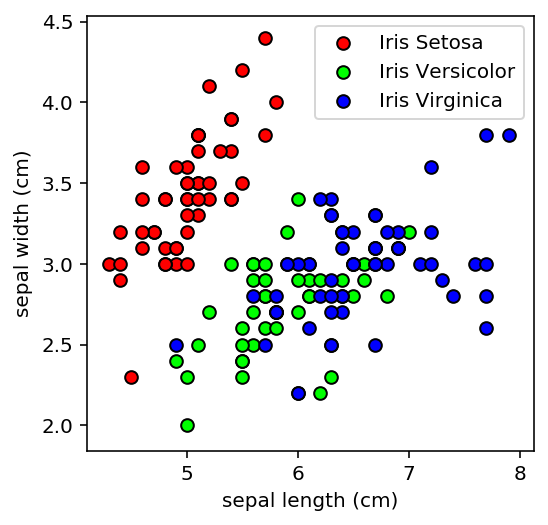

In [15]:
import matplotlib.pyplot as plt
iris = datasets.load_iris()
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000',  '#00FF00', '#0000FF'])

K = 3
x = X[-1]

fig, ax = plt.subplots(figsize=(4,4))
for i, iris_class in enumerate(['Iris Setosa', 'Iris Versicolor', 'Iris Virginica']):
    idx = y==i
    ax.scatter(X[idx,0], X[idx,1], 
               c=cmap_bold.colors[i], edgecolor='k', 
               s=40, label=iris_class);
ax.set(xlabel='sepal length (cm)', ylabel='sepal width (cm)')
ax.legend();

_Machine Learning Algorithms + Voting classifiers_

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

log_clf = LogisticRegression(random_state=42)
dt_clf = DecisionTreeClassifier(random_state=42)
nb_clf = GaussianNB()
knn_clf = neighbors.KNeighborsClassifier(n_neighbors=5)

vclf = VotingClassifier(estimators=[('lr', log_clf), 
                                    ('dt', dt_clf), 
                                    ('knn', knn_clf)], voting='hard')

_Decision boundaries_

In [17]:
def decision_boundary(model, title): 
    ''' model = machine learning algorithm
        title = name of ML algo...'''
    model.fit(X, y)

    # step size in mesh
    h = 0.02

    # decision boundary
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.figure(figsize=(4,4))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    
    # Plot points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold);
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(title)

    plt.show()

Logistic regression, decision trees, and k nearest neigbors are used.

Accuracy: 0.77 (+/- 0.07) [Logistic Regression]


<Figure size 432x288 with 0 Axes>

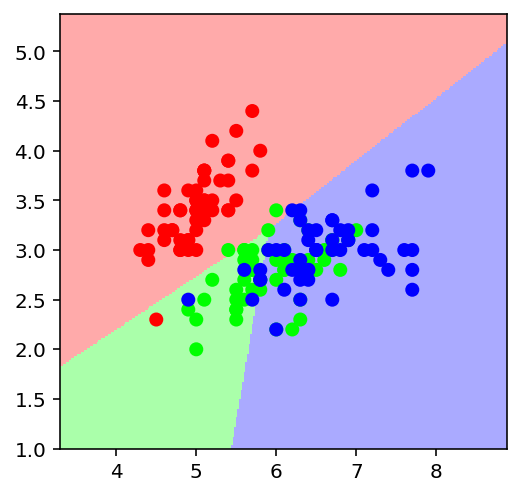

Accuracy: 0.71 (+/- 0.03) [Decision Trees]


<Figure size 432x288 with 0 Axes>

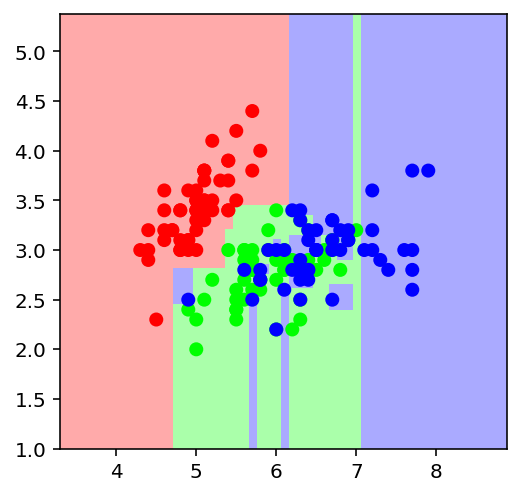

Accuracy: 0.77 (+/- 0.06) [k-NN]


<Figure size 432x288 with 0 Axes>

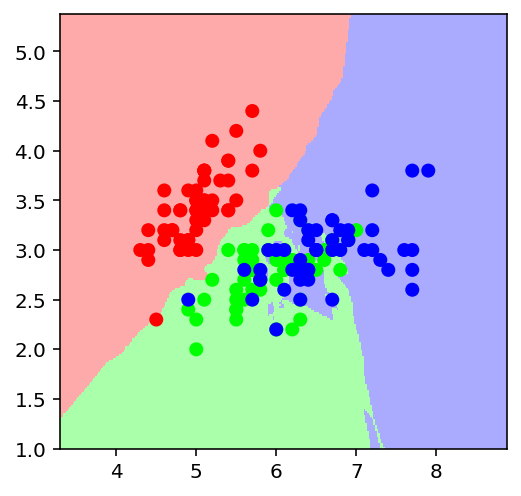

Accuracy: 0.76 (+/- 0.04) [Voting]


<Figure size 432x288 with 0 Axes>

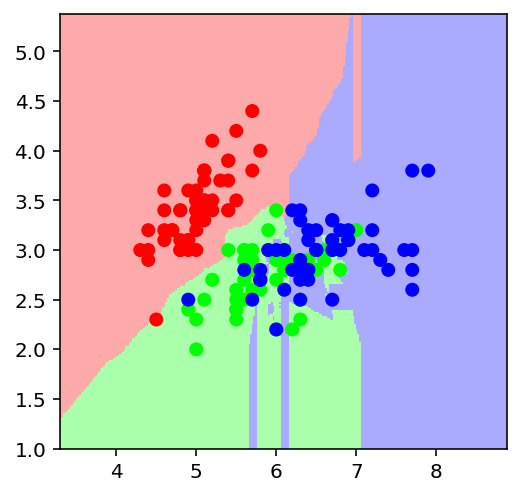

In [18]:
from sklearn.model_selection import cross_val_score

for clf, label in zip([log_clf, dt_clf, knn_clf, vclf], 
                      ['Logistic Regression', 
                       'Decision Trees', 
                       'k-NN', 'Voting']):
    scores = cross_val_score(clf, X, y, scoring='accuracy', cv=5)
    decision_boundary(clf, print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label)));

## 3. Bagging/Pasting
<a id="3"></a>

In Bagging (technically `bootstrap aggregating`), different random subset of the training sample set are used to train the base classifiers. In bagging, sampling is done with replacement, while for pasting, sampling is carried out without replacement. Also note that any classifier can be used as the base classifier. 

<img align='center' src='datasets/random_forest/bagging.png' width=80%/>

**Implementation**

In [19]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(random_state=42), 
                            bootstrap=True)
paste_clf = BaggingClassifier(DecisionTreeClassifier(random_state=42), 
                            bootstrap=False)

Accuracy: 0.71 (+/- 0.03) [Decision Tree]


<Figure size 432x288 with 0 Axes>

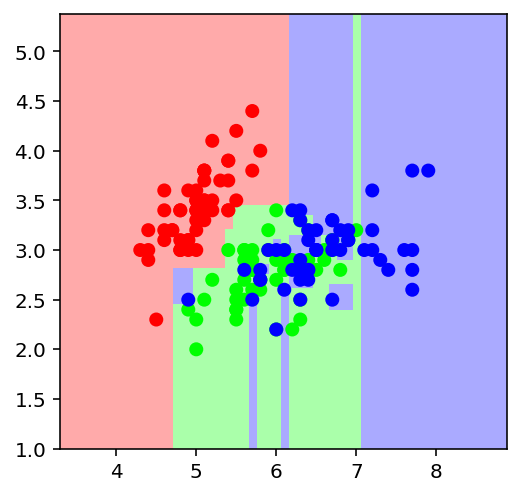

Accuracy: 0.73 (+/- 0.04) [Bagging]


<Figure size 432x288 with 0 Axes>

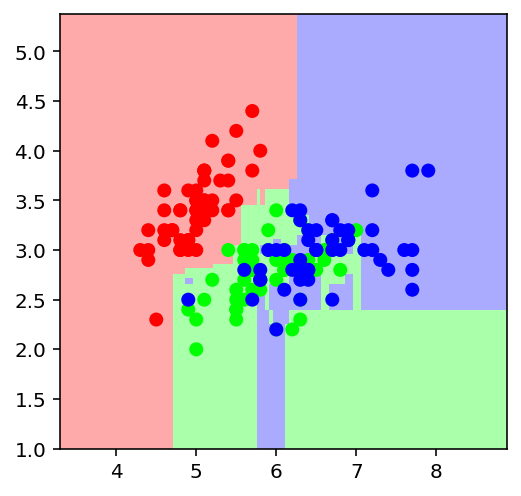

Accuracy: 0.73 (+/- 0.04) [Pasting]


<Figure size 432x288 with 0 Axes>

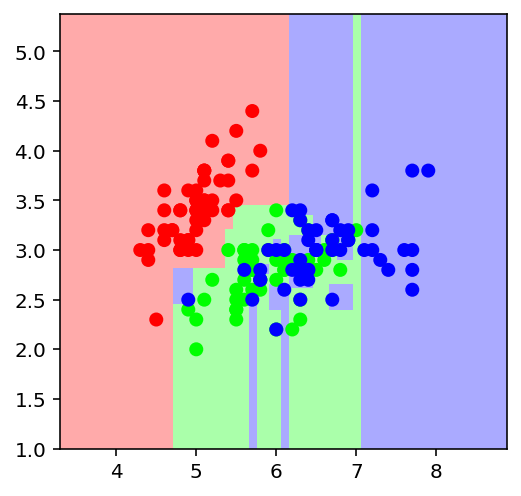

In [21]:
for clf, label in zip([dt_clf, bag_clf, paste_clf], 
                      ['Decision Tree', 
                       'Bagging', 'Pasting']):
    scores = cross_val_score(clf, X, y, 
                             scoring='accuracy', 
                             cv=5)
    decision_boundary(clf, print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label)));

## 4. AdaBoost
<a id="4"></a>

Another interesting ensemble method is adaptive boosting. It basically involves a sequential boosting of the decision tree base clasifier (via tree stumps) by ascribing larger weights to misclassified samples, so that incorrect classification will be corrected in the subsequent decision tree. Hence, adaptive boosting. The final predictor is a linear combination of all the individual predictors.

Mathematically we describe the system as the following: 


$$ \large r_{j} = \dfrac{\sum_{i=1}^{m}w^{(i)}I(y^{(i)} \neq \hat{y}_{j}^{(i)})}{\sum_{i=1}^{m}w^{(i)}}$$

Where $r_{j}$ is the weight error rate and $\hat{y}_{j}^{(i)}$ is j-th base classifier's prediction for the i-th instance. 

$$ \large \alpha_{j} = \eta log \dfrac {1-r_{j}}{r_{j}}$$

Where $\alpha$ is the classifiers' weight and $\eta$ is the learning rate.

While the update process proceed as the following: 
$$\large  w^{(i)} = 
\begin{cases}
w^{(i)} & \text{ if } y^{(i)} = \hat{y}_{j}^{(i)} \\
w^{(i)}\exp(\alpha_{j}) & \text{ if } y^{(i)} \neq \hat{y}_{j}^{(i)}
\end{cases}$$

And then the cycle continues...

A pictoral illustration is shown below.

<img align='center' src='datasets/random_forest/AdaBoost.png' width=70%/>

**Implementation**

In [42]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(random_state=42, n_estimators=50)

scores = cross_val_score(clf, X, y, cv=5)
scores.mean()

0.6333333333333333

## 6. References and Resources
<a id="6"></a>

- __[Scikit Learn, Ensemble method documentation](https://scikit-learn.org/stable/modules/ensemble.html)__
- __[StatQuest with Josh Starmer, AdaBoost Clearly Explained](https://www.youtube.com/watch?v=LsK-xG1cLYA&t=144s)__
- Hands-On Machine Learning with Scikit-Learn & TensorFlow, Chapter 7: Ensemble Learning and Random Forests